In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import librosa.display
import datetime
import time
import os
import json

from src.data import AcousticSceneMusicSegmentation
from src.utils import print_and_log
from src.models import Segmenter1d

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [3]:
hparams = {
    'checkpoint' : None,
    'freesound_dir' : None,
    'sample_rate' : 16000,
    'n_samples' : 160000,
    'feature_type' : 'mel',
    'random_crop' : True,
    'resize' : None,
    'normalize' : True,
    'standardize' : True,
    'standardize_mean' : 0.4009,
    'standardize_std' : 0.1879,
    'spec_augment' : True,
    'random_volume_reduction' : True,
    'n_epochs' : 50,
    'batch_size' : 16,
    'lr' : 0.0001,
    'hidden_dim' : 512,
    'display_iters' : 100,
    'val_iters' : 1000,
    'n_val_samples' : 1000, 
    'n_early_stopping' : 5 # stop if validation doesn't improve after this number of validation cycles
}

In [4]:
train_dataset = AcousticSceneMusicSegmentation(
    'data/DCASE2018/Task1', 
    'data/nsynth', 
    'train',
    freesound_dir=hparams['freesound_dir'],
    sample_rate=hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=hparams['random_crop'],
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=hparams['spec_augment'],
    random_volume_reduction=hparams['random_volume_reduction']
)

val_dataset = AcousticSceneMusicSegmentation(
    'data/DCASE2018/Task1', 
    'data/nsynth', 
    'val',
    freesound_dir=hparams['freesound_dir'],
    sample_rate=hparams['sample_rate'],
    n_samples=hparams['n_samples'],
    random_crop=False,
    feature_type=hparams['feature_type'],
    resize=hparams['resize'],
    normalize=hparams['normalize'],
    standardize=hparams['standardize'],
    standardize_mean=hparams['standardize_mean'],
    standardize_std=hparams['standardize_std'],
    spec_augment=False,
    random_volume_reduction=hparams['random_volume_reduction']
)

In [5]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=True)

In [6]:
model = Segmenter1d(h_dim=hparams['hidden_dim']).to(device)
print('# of parameters : {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# of parameters : 2327745


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['lr'])

In [8]:
timestamp = datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d-%H%M%S')
results_dir = 'train_results/segmentation/{}'.format(timestamp)
os.makedirs(results_dir)

with open(os.path.join(results_dir, 'hparams.json'), 'w') as fp:
    json.dump(hparams, fp)

log_file = os.path.join(results_dir, 'train_log.txt')
log = open(log_file, 'w')
log.close()
print_and_log('{} {}'.format(train_dataset.__class__.__name__, model.__class__.__name__), log_file)

AcousticSceneMusicSegmentation Segmenter1d


[0,     1] loss : 0.7171
[0,   100] loss : 0.4582
[0,   200] loss : 0.4946
[0,   300] loss : 0.7162
[0,   400] loss : 0.3685
[0,   500] loss : 0.4079
Val - loss : 0.3065


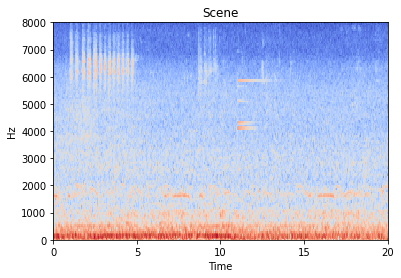

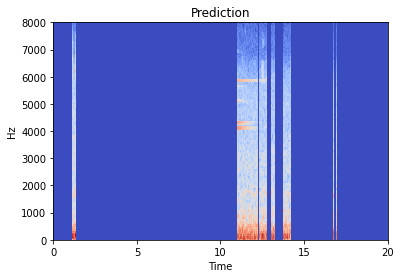

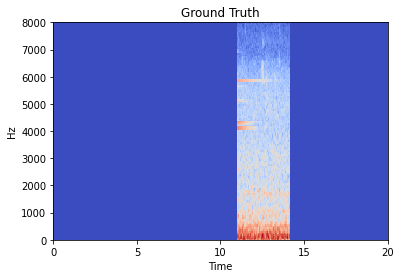

Weights saved in train_results/segmentation/20200730-213912/model-540.weights
[1,   600] loss : 0.2408
[1,   700] loss : 0.2591
[1,   800] loss : 0.2320
[1,   900] loss : 0.2461
[1,  1000] loss : 0.2256
Val - loss : 0.3965


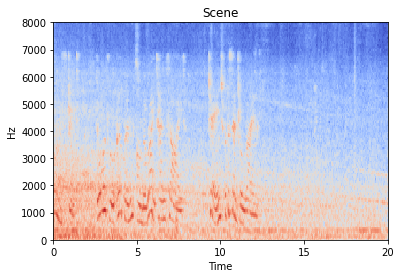

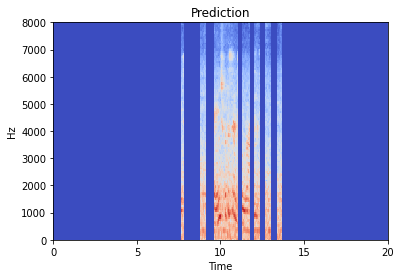

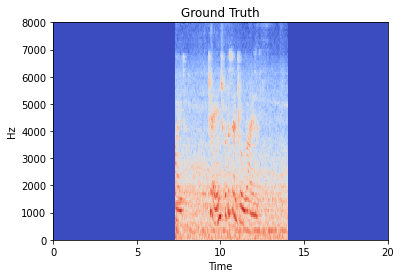

[2,  1100] loss : 0.1881
[2,  1200] loss : 0.3865
[2,  1300] loss : 0.3202
[2,  1400] loss : 0.2528
[2,  1500] loss : 0.3476
[2,  1600] loss : 0.2404
Val - loss : 0.2505


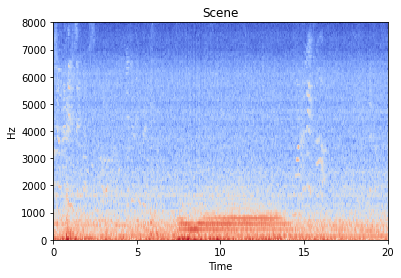

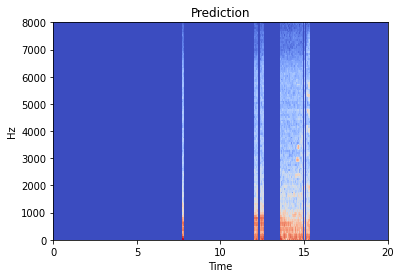

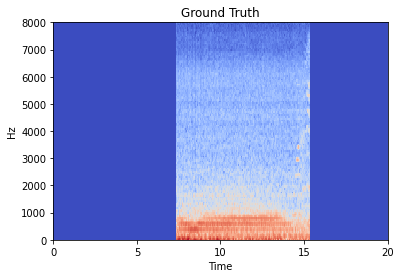

Weights saved in train_results/segmentation/20200730-213912/model-1620.weights
[3,  1700] loss : 0.2564
[3,  1800] loss : 0.1828


In [ ]:
loss_fn = nn.BCELoss()

ckpt_weights_path = None
best_loss = 1e10
since_best = 0
done = False

if hparams['checkpoint']:
    print_and_log('Resuming training from {}'.format(hparams['checkpoint']), log_file)
    ckpt = torch.load(hparams['checkpoint'])
    epoch = ckpt['epoch']
    itr = ckpt['itr']
    optimizer.load_state_dict(ckpt['optimizer'])
    model.load_state_dict(ckpt['model'])
    best_loss = ckpt['best_loss']
else:
    epoch = 0
    itr = 0

for epoch in range(epoch, hparams['n_epochs']):
    if done:
        break
        
    for batch in train_dataloader:
        if done:
            break
            
        itr += 1
        features = batch[0].to(device)
        labels = batch[1].to(device)
        outputs = model(features)
        
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (itr % hparams['display_iters'] == 0) or (itr == 1):
            print_and_log('[{}, {:5d}] loss : {:.4f}'.format(epoch, itr, loss.item()), log_file)
                        
    model.eval()
    with torch.no_grad():
        ct, i, val_loss = 0, 0, 0.0
        for batch in val_dataloader:
            i += 1
            ct += batch[0].size(0)
            features = batch[0].to(device)
            labels = batch[1].to(device)
            outputs = model(features)

            loss = loss_fn(outputs, labels)

            val_loss += (loss.item() - val_loss)/i

            if ct >= hparams['n_val_samples']:
                break
                
    print_and_log('Val - loss : {:.4f}'.format(val_loss), log_file)
    
    # display example segmented spectrogram
    scene = features[0].cpu().numpy().squeeze()
    pred_mask = (outputs[0].detach().cpu().numpy() > 0.5).astype(float)
    true_mask = labels[0].detach().cpu().numpy()
    
    pred_segment = np.ones_like(scene)*scene.min() * (1 - pred_mask) + pred_mask*scene
    true_segment = np.ones_like(scene)*scene.min() * (1 - true_mask) + true_mask*scene

    librosa.display.specshow(scene, sr=16000, x_axis='time', y_axis='hz')
    plt.title('Scene')
    plt.show()
    librosa.display.specshow(pred_segment, sr=16000, x_axis='time', y_axis='hz')
    plt.title('Prediction')
    plt.show()
    librosa.display.specshow(true_segment, sr=16000, x_axis='time', y_axis='hz')
    plt.title('Ground Truth')
    plt.show()

    if val_loss < best_loss:
        since_best = 0
        best_loss = val_loss

        # save weights
        ckpt_weights_path = os.path.join(results_dir, 'model-{}.weights'.format(itr))
        torch.save(model.state_dict(), ckpt_weights_path)
        print_and_log('Weights saved in {}'.format(ckpt_weights_path), log_file)

        # save meta information
        ckpt_meta_path = os.path.join(results_dir, 'checkpoint')
        torch.save({
            'best_loss' : best_loss,
            'epoch' : epoch,
            'itr' : itr,
            'optimizer' : optimizer.state_dict(),
            'model' : model.state_dict()
        }, ckpt_meta_path)
    else:
        since_best += 1
        if since_best >= hparams['n_early_stopping']:
            done = True
            print_and_log('Early stopping... training complete', log_file)

    model.train()